## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install tensorflow-gan

     |████████████████████████████████| 368kB 3.4MB/s 


In [ ]:
# !pip install -q  --no-deps tensorflow-addons~=0.7
!pip install tensorflow-gan

import tensorflow_addons as tfa
import tensorflow_gan as tfgan
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,Activation,Lambda,Concatenate,UpSampling2D,Dropout,Conv2DTranspose
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam


from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import sqrtm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using TensorFlow backend.


87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
def show_images(images,depro=False):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    if depro:
      images = deprocess_img(images)
      sqrtn = 10
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img)
    return

def minimal_show(x):
  x = deprocess_img(x)
  plt.figure(figsize=(14,14))
  plt.subplot(141)
  plt.axis('off')
  plt.title('win')
  plt.imshow(x[0])
  plt.subplot(142)
  plt.title('->sum')
  plt.axis('off')
  plt.imshow(x[1])
  plt.subplot(143)
  plt.axis('off')
  plt.title('sum')
  plt.imshow(x[2])
  plt.subplot(144)
  plt.axis('off')
  plt.title('->win')
  plt.imshow(x[3])
  
  plt.show()


def deprocess_img(x):
    x = (x + 1.0) / 2.0
    return np.uint8(x * 255)

## Dataset


In [ ]:
sum_yos = np.load('/content/drive/My Drive/selected_sum_yos.npy')
win_yos = np.load('/content/drive/My Drive/selected_win_yos.npy')

# sum_yos = np.load('selected_sum_yos.npy')
# win_yos = np.load('selected_win_yos.npy')

sy = np.expand_dims((np.float32(sum_yos[:1000])/127.5)-1,1)
wy = np.expand_dims((np.float32(win_yos[:1000])/127.5)-1,1)
print(sy.shape)

del sum_yos
del win_yos

(1000, 1, 256, 256, 3)


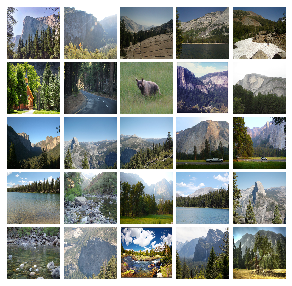

In [ ]:
show_images(np.squeeze(deprocess_img(sy[:25])))


# Utils

In [ ]:
def reflect_pad(x,p):
  padding = tf.constant([[0,0],[p,p],[p,p],[0,0]])
  return tf.pad(x,padding,mode='REFLECT')

def Conv_Block(x,f,k=7,s=1,act=tf.nn.relu):
  #ReflectivePadding-Conv-InstanceNorm-Relu
  a = reflect_pad(x,(k-1)//2)
  a = Conv2D(f,k,strides=s,kernel_initializer=tf.random_normal_initializer(mean=0,stddev=.02))(a)
  a = tfa.layers.InstanceNormalization()(a)
  a = act(a)
  return a

def Res_Block(x,f,k=3,s=1):
  a1 = Conv_Block(x,f,k,s)
  a2 = Conv_Block(a1,f,k,s)
  a = x + a2
  return a

def ConvT2D_Block(x,f,k=3,s=2):
  a = Conv2DTranspose(f,k,strides=s,padding='SAME')(x)
  a = tfa.layers.InstanceNormalization()(a)
  a = tf.nn.relu(a)
  return a

def calc_FID(imgs1,imgs2):
    
    imgs1 = tf.image.resize(imgs1,[299,299])
    imgs2 = tf.image.resize(imgs2,[299,299])
    imgs1 = preprocess_input(imgs1)
    imgs2 = preprocess_input(imgs2)
    
    p0 = model.predict_on_batch(imgs1)
    p1 = model.predict_on_batch(imgs2)
    # p0 = np.uint8(tf.multiply(p0,100))
    # p1 = np.uint8(tf.multiply(p1,100))
    # a = np.mean(np.square(p0 - p1))
    # c1, c2 = np.cov(p0,rowvar=0), np.cov(p1,rowvar=0)
    # b = np.trace(c1 + c2 -2 * np.real(sqrtm(np.dot(c1,c2))))
    # FID = a + b
    ############### a little faster than manual implementaiton
    FID = tfgan.eval.frechet_classifier_distance_from_activations(p0, p1)
    return FID

def calc_IS(imgs1,n_split=5):
    
    imgs1 = tf.image.resize(imgs1,[299,299])
    imgs1 = preprocess_input(imgs1)
    
    p0 = model.predict_on_batch(imgs1)
    b = tf.convert_to_tensor(tf.split(p0,5),dtype=tf.float64)
    c = tf.reduce_mean(b,1,keepdims=True)
    d = b * (tf.math.log(b+1e-16)-tf.math.log(c+1e-16))
    Scores = tf.math.exp(tf.reduce_mean(tf.reduce_sum(d,2,keepdims=1),1))
    return (tf.reduce_mean(Scores))

## Generator


In [ ]:
def U_generator():
  f = 32
  act = tf.nn.leaky_relu
  def enc_block(a,f,k=4):
    a = Conv2D(filters=f,kernel_size=k,strides=(2,2),padding='SAME',activation=act)(a)
    a = tfa.layers.InstanceNormalization()(a)
    return a
  def dec_block(a,b,f,k=4,dropout_rate=0):
    a = UpSampling2D(size=(2,2))(a)
    a = Conv2D(filters=f,kernel_size=k,padding='SAME',activation='relu')(a)
    if dropout_rate:
      a = Dropout(rate=dropout_rate)(a)
    a = tfa.layers.InstanceNormalization()(a)
    a = Concatenate()([a,b])
    return a
  
  il = Input(shape=(256,256,3))
  e1 = enc_block(il,f*1)
  e2 = enc_block(e1,f*2)
  e3 = enc_block(e2,f*4)
  e4 = enc_block(e3,f*8)

  d1 = dec_block(e4,e3,f*4)
  d2 = dec_block(d1,e2,f*2)
  d3 = dec_block(d2,e1,f*1)
  d4 = UpSampling2D(size=(2,2))(d3)
  out = Conv2D(3,4,padding='SAME',activation='tanh')(d4)
  
  model = Model(inputs=il,outputs=out)
  return model

def R_generator():
  f = 64
  I = Input((256,256,3))
  a = Conv_Block(I,f)
  a = Conv_Block(a,2*f,k=3,s=2)
  a = Conv_Block(a,4*f,k=3,s=2)
  for i in range(9):
    a = Res_Block(a,4*f)
  a = ConvT2D_Block(a,2*f)
  a = ConvT2D_Block(a,1*f)
  a = Conv_Block(a,3,act=tf.nn.tanh)
  return Model(inputs=I, outputs=a)

## Discriminator


In [ ]:
def discriminator():
  f = 64
  act = tf.nn.leaky_relu
  def block(a,f,k=4,Normalization=True):
    a = Conv2D(f,k,strides=(2,2),padding='SAME')(a)
    if Normalization:
      a = tfa.layers.InstanceNormalization()(a)
    a = tf.nn.leaky_relu(a) 
    return a
  il = Input(shape=(256,256,3))
  b1 = block(il,1*f,Normalization=0)
  b2 = block(b1,2*f,Normalization=1)
  b3 = block(b2,4*f,Normalization=1)
  b4 = block(b3,8*f,Normalization=1)
  out = Conv2D(1,kernel_size=4,padding='SAME')(b4)
  model = Model(inputs=il,outputs=out)
  return model

In [ ]:
def discriminator_loss(logits_real, logits_fake):
  l1 = tf.reduce_mean(tf.square(tf.ones_like(logits_real)-logits_real))
  l2 = tf.reduce_mean(tf.square(logits_fake))
  loss = .5 * (l1+l2)
  return loss

def generator_loss(logits_fake,x_real,target_domain_recons,identity_recons,landa,landa2):
  adv_loss = tf.reduce_mean(tf.square(tf.ones_like(logits_fake)-logits_fake))
  r1 = tf.reduce_mean(tf.abs(x_real-target_domain_recons))
  r2 = tf.reduce_mean(tf.abs(x_real-identity_recons))
  loss = adv_loss + landa*r1 + landa2 *r2
  return loss

In [ ]:
D1 = discriminator()
D2 = discriminator()

G1 = R_generator()
G2 = R_generator()

D_solver = Adam(learning_rate=1e-4,beta_1=.5)
G_solver = Adam(learning_rate=1e-4,beta_1=.5)


In [ ]:
def train(D1,D2, G1,G2, D_solver, G_solver, discriminator_loss, generator_loss,\
              save_every=80,batch_size=128, num_epochs=10,lr_decay=0):
    
    landa = 10 #cycle consistency coeff.
    landa2 = .1 * 10 #identitiy reconstruction coeff.
    
    Buff_D1 = np.zeros((50,256,256,3),dtype=np.float32)
    Buff_D2 = np.zeros_like(Buff_D1)
    R_BUFF = np.zeros_like(Buff_D1)
    R2_BUFF = np.zeros_like(Buff_D1)
    idxs1 = np.arange(1000)
    idxs2 = np.arange(1000)
    
    for epoch in range(num_epochs):
        random.shuffle(idxs1)
        random.shuffle(idxs2)
            
        for i in range(1000):
            xs,xw = sy[idxs1[i]],wy[idxs2[i]]
            R_BUFF[i%50] = xs
            R2_BUFF[i%50] = xw
            with tf.GradientTape() as tape:
                idx = min(i+1,50)
                fake_xw = G1(xs)
                Buff_D1[i%50] = fake_xw
                l1_fake = D1(Buff_D1[:idx])
                l1_real = D1(xw)
                
                fake_xs = G2(xw)
                Buff_D2[i%50] = fake_xs
                l2_fake = D2(Buff_D2[:idx])
                l2_real = D2(xs)
              
                D1_total_error = discriminator_loss(l1_real, l1_fake)
                D2_total_error = discriminator_loss(l2_real, l2_fake)
                d_total_error = D1_total_error + D2_total_error
            d_gradients = tape.gradient(d_total_error, D1.trainable_variables+D2.trainable_variables)      
            D_solver.apply_gradients(zip(d_gradients, D1.trainable_variables+D2.trainable_variables))
            
            with tf.GradientTape() as tape:
                f_fake_xw = G1(fake_xs)
                f2_fake_xw = G1(xw)
                
                f_fake_xs = G2(fake_xw)
                f2_fake_xs = G2(xs)
                
                g1_loss = generator_loss(l1_fake,xw,f_fake_xw,f2_fake_xw,landa,landa2)
                g2_loss = generator_loss(l2_fake,xs,f_fake_xs,f2_fake_xs,landa,landa2)

                g_total_error = g1_loss + g2_loss

            g_gradients = tape.gradient(g_total_error, G1.trainable_variables+G2.trainable_variables)      
            G_solver.apply_gradients(zip(g_gradients, G1.trainable_variables+G2.trainable_variables))
            
            if (i % save_every == 0):
                FIDs.append((calc_FID(R2_BUFF,Buff_D1) + calc_FID(R_BUFF,Buff_D2))*.5)

                print('Epoch: {}, Iter: {}, D: {:.4}, G:{:.4}, FIDs:{:.4}'.format(epoch, i,d_total_error,g_total_error,FIDs[-1]))
                # G1.save_weights('/content/drive/My Drive/G1/')
                # G2.save_weights('/content/drive/My Drive/G2/')
                # D1.save_weights('/content/drive/My Drive/D1/')
                # D2.save_weights('/content/drive/My Drive/D2/')
                xs_numpy = fake_xs.cpu().numpy()
                xw_numpy = fake_xw.cpu().numpy()
                minimal_show(np.concatenate((xw,xs_numpy,xs,xw_numpy)))
                del xw_numpy
                del xs_numpy
                np.save('/content/drive/My Drive/FIDs.npy',FIDs)


In [ ]:
G1.load_weights('/content/drive/My Drive/G1/')
G2.load_weights('/content/drive/My Drive/G2/')
D1.load_weights('/content/drive/My Drive/D1/')
D2.load_weights('/content/drive/My Drive/D2/')

FIDs = np.load('/content/drive/My Drive/FIDs.npy').tolist()

In [ ]:
train(D1, D2, G1, G2, D_solver, G_solver, discriminator_loss, generator_loss,batch_size= 1,save_every=250,num_epochs=10)